In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 454.3MB 22kB/s 


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import datetime
import sys
import os
import numpy as np
import pandas as pd
import sklearn 
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras import Sequential
import tensorflow.keras.backend as K
from keras.layers import (Input, Dense, Lambda, TimeDistributed, LSTM, GRU, Dropout, merge, 
                         Concatenate, Flatten, RepeatVector, Bidirectional, SimpleRNN)
from keras.models import Model
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
from tensorflow.keras.callbacks import (Callback, TensorBoard, EarlyStopping,
                             ModelCheckpoint, CSVLogger, ProgbarLogger)
import sys
import csv
from collections import Iterable, OrderedDict
import datetime
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  """


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading AGN light curves

In [ ]:
#reading list of lcs already saved 
#lcs= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_final_sample_lcs_gband_lcs_list.npy',allow_pickle=True)
#lcs= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_largechi2_noblazar_sample_lcs_gband_lcs_list.npy',allow_pickle=True)
#lcs= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_anomalous_noblazar_var_sample_lcs_gband_lcs_list.npy',allow_pickle=True)
#lcs= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/Frederick_Ricci_targets_gband_lcs_list.npy',allow_pickle=True)
#lcs= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_anomalous_NLS1_sample_lcs_gband_lcs_list.npy',allow_pickle=True)
#lcs= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_csagncand_sample_lcs_gband_lcs_list.npy',allow_pickle=True)
#lcs= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_anomQSO_IFscore_lcs_gband_lcs_list.npy',allow_pickle=True)
lcs= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_CSAGN_cand_recent_gband_lcs_list.npy',allow_pickle=True)

#reading list of oids already saved 
#oids_fids= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_final_sample_lcs_gband_oid_list.npy',allow_pickle=True)
#oids_fids= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_largechi2_noblazar_sample_lcs_gband_oid_list.npy',allow_pickle=True)
#oids_fids= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_anomalous_noblazar_var_sample_lcs_gband_oid_list.npy',allow_pickle=True)
#oids_fids= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/Frederick_Ricci_targets_gband_oid_list.npy',allow_pickle=True)
#oids_fids= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_anomalous_NLS1_sample_lcs_gband_oid_list.npy',allow_pickle=True)
#oids_fids= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_csagncand_sample_lcs_gband_oid_list.npy',allow_pickle=True)
#oids_fids= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_anomQSO_IFscore_lcs_gband_oid_list.npy',allow_pickle=True)
oids_fids= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/DR5_VAE_32_16_CSAGN_cand_recent_gband_oid_list.npy',allow_pickle=True)


In [ ]:
print(len(oids_fids))

12


In [ ]:
#lcs = lcs[120000:150000]
#oids_fids = oids_fids[120000:150000]

In [ ]:
print(oids_fids[0:10])

[[451103200005537]
 [495111100005833]
 [566112100004425]
 [646113100002570]
 [648101400002016]
 [649113400004567]
 [674113200005713]
 [678115400001961]
 [693106300007466]
 [712112100003746]]


In [ ]:
#padding the lcs
lcs_raw = pad_sequences(lcs, value=np.nan, dtype='float', padding='post')

**Preprocess for the input data:** 

MJD -> $\Delta$MJD/365.0

mag -> [mag - mean(mag)]/std(mag)

In [ ]:
def times_to_lags(T):
    """(N x n_step) matrix of times -> (N x n_step) matrix of lags.
    First time is assumed to be zero.
    """
    assert T.ndim == 2, "T must be an (N x n_step) matrix"
    return np.c_[np.diff(T, axis=1)/365., np.zeros(T.shape[0])]


def preprocess(X_raw, m_max=np.inf):
    X = X_raw.copy()
    print(X.shape)
    wrong_units =  np.all(np.isnan(X[:, :, 1])) | (np.nanmax(X[:, :, 1], axis=1) > m_max)
    X = X[~wrong_units, :, :]
    X[:, :, 0] = times_to_lags(X[:, :, 0])
    means = np.atleast_2d(np.nanmean(X[:, :, 1], axis=1)).T
    X[:, :, 1] -= means
    scales = np.atleast_2d(np.nanstd(X[:, :, 1], axis=1)).T
    X[:, :, 1] /= scales
    errors = X[:, :, 2] / scales
    X = X[:, :, :2]
    print(X.shape)
    return X, means, scales, errors, wrong_units

In [ ]:
lcs_scaled, means, scales, errors, wrong_units = preprocess(lcs_raw)

(12, 553, 3)
(12, 553, 2)


In [ ]:
print(lcs_scaled[0])

[[ 0.0274376  -1.32299392]
 [ 0.01639758 -1.22907791]
 [ 0.00816169 -1.32114143]
 ...
 [        nan         nan]
 [        nan         nan]
 [ 0.                 nan]]


In [ ]:
print(lcs_raw)

[[[5.83044632e+04 1.77298660e+01 2.63450723e-02]
  [5.83144779e+04 1.77579117e+01 2.67319083e-02]
  [5.83204630e+04 1.77304192e+01 2.63526049e-02]
  ...
  [           nan            nan            nan]
  [           nan            nan            nan]
  [           nan            nan            nan]]

 [[5.82854420e+04 2.07285671e+01 1.67948842e-01]
  [5.82914413e+04 2.08288326e+01 1.75302744e-01]
  [5.82954452e+04 2.05564804e+01 1.55327201e-01]
  ...
  [           nan            nan            nan]
  [           nan            nan            nan]
  [           nan            nan            nan]]

 [[5.82051526e+04 1.83085155e+01 2.89182924e-02]
  [5.82271864e+04 1.83583660e+01 2.98638903e-02]
  [5.82351972e+04 1.83525734e+01 2.97518689e-02]
  ...
  [           nan            nan            nan]
  [           nan            nan            nan]
  [           nan            nan            nan]]

 ...

 [[5.82022764e+04 1.91161423e+01 6.09129816e-02]
  [5.82052526e+04 1.90119324e+01 5.6550

In [ ]:
main_input = Input(shape=(lcs_scaled.shape[1], 2), name='main_input') #(lag, mag)
aux_input = Input(shape=(lcs_scaled.shape[1], 1), name='aux_input') #(lag)
model_input = [main_input, aux_input]

In [ ]:
sample_weight = 1. / errors
sample_weight[np.isnan(sample_weight)] = 0.0
lcs_scaled[np.isnan(lcs_scaled)] = 0.

##Reading the VAE model 

- Use the following cells to read the model weights from the local folder.

In [ ]:
def sampling(samp_args):
    z_mean, z_log_sigma = samp_args

    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

In [ ]:
lr = 1e-4 #learning rate 
optimizer = Adam(lr=lr)
output_size=16
gru_size = 32
nepochs = 2000
batchsize = 512
dropout_val = 0.25


#encoder
encoder = Bidirectional(GRU(gru_size, name='encoder1', return_sequences=True))(main_input)
encoder = Dropout(dropout_val, name='drop_encoder1')(encoder) 
encoder = Bidirectional(GRU(gru_size, name='encoder2', return_sequences=False))(encoder)
encoder = Dropout(dropout_val, name='drop_encoder2')(encoder)
codings_mean = Dense(units=output_size, name='encoding_mean', activation='linear')(encoder)
codings_log_var = Dense(units=output_size, name='encoding_log_var', activation='linear')(encoder) 
codings = Lambda(sampling, output_shape=(output_size,))([codings_mean, codings_log_var])


#decoder
decoder = RepeatVector(lcs_scaled.shape[1], name='repeat')(codings)
decoder = merge.concatenate([aux_input, decoder])
decoder = GRU(gru_size, name='decoder1', return_sequences=True)(decoder)
decoder = Dropout(dropout_val, name='drop_decoder1')(decoder)
decoder = GRU(gru_size, name='decoder2', return_sequences=True)(decoder)
decoder = TimeDistributed(Dense(1, activation='linear'), name='time_dist')(decoder)

#VAE
model = Model(model_input, decoder)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
log_dir = '/content/drive/MyDrive/CSAGNs/models_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/'
weights_path = os.path.join(log_dir, 'weights_lr1e3_4paper.h5')

lr = 1e-3 #learning rate 
optimizer = Adam(lr=lr)

model.load_weights(weights_path)

latent_loss = -0.5*K.sum(1+codings_log_var-K.exp(codings_log_var)-K.square(codings_mean),axis=-1)
model.add_loss(K.mean(latent_loss)/200.)
model.compile(optimizer=optimizer, loss='mse',  metrics=[tf.keras.metrics.MeanAbsoluteError()], weighted_metrics=[tf.keras.metrics.MeanAbsoluteError()], sample_weight_mode='temporal')#,run_eagerly=True)

#model.compile(optimizer=optimizer, loss='mse',  sample_weight_mode='temporal')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 553, 2)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 553, 64)      6912        main_input[0][0]                 
__________________________________________________________________________________________________
drop_encoder1 (Dropout)         (None, 553, 64)      0           bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64)           18816       drop_encoder1[0][0]              
______________________________________________________________________________________________

Dividing the model into the encoding and the decoding parts, and getting encoded features and decoded light curves

In [ ]:

decode_model = Model(model.input, model.output)

encode_mean = Model(model.input, model.get_layer('encoding_mean').output)
encode_log_var = Model(model.input, model.get_layer('encoding_log_var').output)

In [ ]:
encoding_mean = encode_mean.predict({'main_input': lcs_scaled, 'aux_input': np.delete(lcs_scaled, 1, axis=2)})
encoding_log_var = encode_log_var.predict({'main_input': lcs_scaled, 'aux_input': np.delete(lcs_scaled, 1, axis=2)})


In [ ]:
decoding_10 = []

for i in range(10):
  decoding_aux = decode_model.predict({'main_input': lcs_scaled, 'aux_input': np.delete(lcs_scaled, 1, axis=2)})
  decoding_10.append(decoding_aux)

  #if i%10 == 0:
  print('.', end='')

decoding_10 = np.array(decoding_10)


..........

In [ ]:
decoding_median = np.nanmedian(decoding_10,axis=0)
decoding_mean = np.nanmean(decoding_10,axis=0)
decoding_std = np.nanstd(decoding_10,axis=0)
decoding_low = np.nanmin(decoding_10,axis=0)
decoding_high = np.nanmax(decoding_10,axis=0)

In [ ]:
print(len(decoding_mean))

12


In [ ]:
print(decoding_mean)

[[[-1.3452377 ]
  [-1.2819171 ]
  [-1.1893532 ]
  ...
  [ 0.4037822 ]
  [ 0.40285158]
  [ 0.40189585]]

 [[ 0.95807916]
  [ 1.0807153 ]
  [ 1.0773938 ]
  ...
  [ 0.63667834]
  [ 0.635362  ]
  [ 0.6339913 ]]

 [[ 1.1794708 ]
  [ 1.9041517 ]
  [ 1.9443327 ]
  ...
  [ 0.64011186]
  [ 0.6418788 ]
  [ 0.64364433]]

 ...

 [[ 0.99415624]
  [ 1.2933311 ]
  [ 1.3490678 ]
  ...
  [ 0.4375817 ]
  [ 0.43816406]
  [ 0.43882266]]

 [[ 0.70596933]
  [ 0.5706465 ]
  [ 0.5692497 ]
  ...
  [-1.538688  ]
  [-1.5326986 ]
  [-1.5262944 ]]

 [[-0.46400413]
  [-0.4706745 ]
  [-0.46229973]
  ...
  [ 0.66359365]
  [ 0.6728534 ]
  [ 0.67904305]]]


Computing reduced chi-square distribution 

In [ ]:
def calc_redchisq(x, x_pred, weight, x_pred_err):
    mask =  (~np.isnan(weight))
    out = np.sum((((x[mask]-x_pred[mask]))**2)/(weight[mask]**-2+x_pred_err[mask]**2))/len(weight[mask])
    return out

RedChiSq = []
print('Caluculating reduced chi-square for each source')
for m in range(0, len(lcs_raw)):
    if m%100 == 0:
        print('.', end='')
    RedChiSq.append(calc_redchisq(lcs_scaled[m][:,1]*scales[m]+means[m], np.squeeze(decoding_mean[m]*scales[m]+means[m]), 1/lcs_raw[m][:,2],np.squeeze(decoding_std[m]*scales[m])))

Caluculating reduced chi-square for each source
.

In [ ]:
print(RedChiSq)

[2.741926403227124, 2.690126018881052, 3.146674972394374, 1.1276919689786755, 1.701624086692311, 1.1414807549166295, 3.786827609950153, 18.390550368965272, 2.983600174339058, 1.891484241045782, 4.831880155000056, 1.319464847285751]


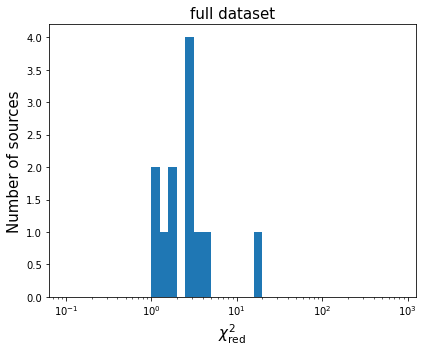

In [ ]:
plt.figure(figsize=(6,5))
plt.hist(np.array(RedChiSq)[~np.isnan(RedChiSq)], 
         bins=10**np.arange(-1, 3, 0.1))
plt.xscale('log')
plt.xlabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.title('full dataset', fontsize=15)
plt.tight_layout()
plt.show()

 Example of sources showing a large $\chi_{\rm red}^2$

In [ ]:
len_list = []
for i in range(0,len(lcs)):
    len_list.append(len(lcs[i]))

chi_mask = np.array(RedChiSq) >=0

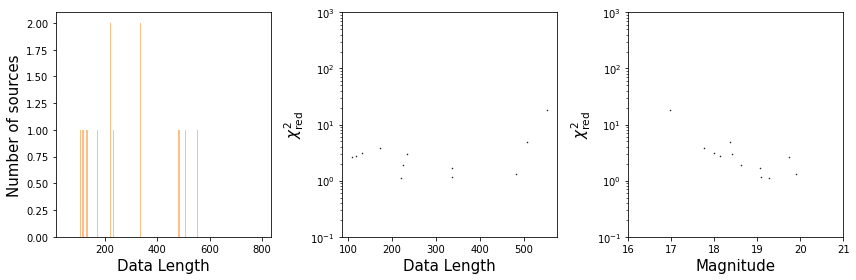

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.hist(np.array(len_list)[~chi_mask], bins=np.arange(50, 800, 5), alpha=0.5)
plt.hist(np.array(len_list)[chi_mask], bins=np.arange(50, 800, 5), alpha=0.5)
plt.xlabel('Data Length', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.subplot(1,3,2)
plt.scatter(len_list, RedChiSq, alpha=1, s=0.25, color='black')
plt.xlabel('Data Length', fontsize=15)
plt.ylabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylim(1e-1, 1e3)
plt.yscale('log')
plt.subplot(1,3,3)
plt.scatter(np.nanmean(lcs_raw[:, :, 1], axis=1), RedChiSq, alpha=1, s=0.25, color='black')
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylim(1e-1, 1e3);plt.xlim(16, 21)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
len_mask = (np.array(len_list)>=50) & (np.array(len_list)<1200)
bad_fitting_mask = len_mask&chi_mask


In [ ]:
oids_all = np.array(oids_fids)[:,0]
#print(oids_all)

In [ ]:
encoding_val = encoding_mean[bad_fitting_mask]
decoding_val_mean = decoding_mean[bad_fitting_mask]
decoding_val_std = decoding_std[bad_fitting_mask]

decoding_val_median = decoding_median[bad_fitting_mask]
decoding_val_low = decoding_low[bad_fitting_mask]
decoding_val_high = decoding_high[bad_fitting_mask]

X_raw_val = lcs_raw[bad_fitting_mask ]
X_val = lcs_scaled[bad_fitting_mask ]
scales_val = scales[bad_fitting_mask ]
means_val = means[bad_fitting_mask ]
oids_val = oids_all[bad_fitting_mask]
print(len(encoding_val))

12


In [ ]:
print(oids_val)

[451103200005537 495111100005833 566112100004425 646113100002570
 648101400002016 649113400004567 674113200005713 678115400001961
 693106300007466 712112100003746 719114100002677 795106100002111]


451103200005537
495111100005833
566112100004425
646113100002570
648101400002016
649113400004567


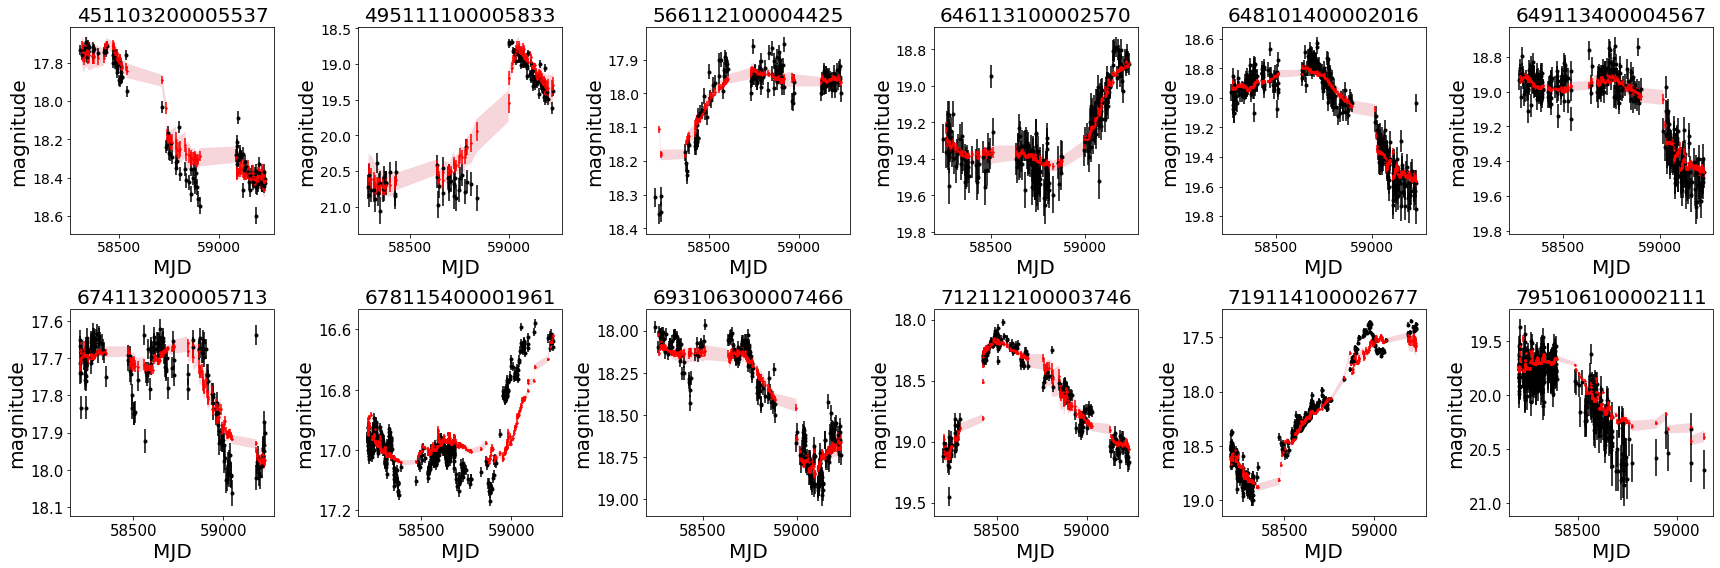

In [ ]:
fignum = 6#6,3
i = 0
k=0
fig = plt.figure(figsize=(24,8))#plt.figure(figsize=(11,4))#plt.figure(figsize=(25,9))

#ids =  [3,4,9,0,1,2]#[0,1,2,3,4,5]#np.random.randint(0,10000, size=6)
#ids2 =  [5,6,7,8,10,11]#[6,7,8,9,10,11]#np.random.randint(0,10000, size=6)

#plotting raw-lightcurves and the decoded lightcurves 
#for num in [3,4,9]:
for num in range(i,i+fignum):
    ax= fig.add_subplot(2,fignum, k+1)
    #print(X_raw_val[num][:,0])
    #print(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0]))
    print(oids_val[num])
    #print((decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten())
    ax.set_title(oids_val[num],fontsize=20)
    ax.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=3)
    ax.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>0]*scales_val[num]).flatten(), fmt='.', color='red', ms=3)
    ax.fill_between(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], (decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(), (decoding_val_high[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(),alpha=0.2,  facecolor='#D42F4B')
    ax.set_ylim(plt.ylim()[::-1])
    ax.set_xlabel('MJD',fontsize=20)
    ax.set_ylabel('magnitude',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    k += 1

i = fignum

#for num in ids2:
for num in range(i,i+fignum):
    ax= fig.add_subplot(2,fignum, k+1)
    #print(X_raw_val[num][:,0])
    #print(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0]))
    #print(oids_val[num])
    #print((decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten())
    ax.set_title(oids_val[num],fontsize=20)
    ax.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=3)
    ax.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>0]*scales_val[num]).flatten(), fmt='.', color='red', ms=3)
    ax.fill_between(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], (decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(), (decoding_val_high[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(),alpha=0.2,  facecolor='#D42F4B')
    ax.set_ylim(plt.ylim()[::-1])
    ax.set_xlabel('MJD',fontsize=20)
    ax.set_ylabel('magnitude',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    k += 1

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CSAGNs/plots_4paper/recent_sdss_spec_sample_modeling.pdf')


In [ ]:
'''oid_ZTF = ["ZTF19abvgxrq","ZTF19aaiqmgl","ZTF18aaabltn","ZTF18aaabltn","ZTF19aatubsj","ZTF18aaidlyq",
           "ZTF18aahiqfi","ZTF18aajupnt","ZTF18aasszwr","ZTF18aasuray","ZTF18abjjkeo"]

fignum = 6
i = 0
k=0
fig = plt.figure(figsize=(25, 9))


#plotting raw-lightcurves and the decoded lightcurves 
for num in range(i,i+fignum):
    ax= fig.add_subplot(2, fignum, k+1)
    #print(X_raw_val[num][:,0])
    #print(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0]))
    #print(oids_val[num])
    #print((decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten())
    ax.set_title(oid_ZTF[num],fontsize=20)
    ax.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=3)
    ax.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>0]*scales_val[num]).flatten(), fmt='.', color='red', ms=3)
    ax.fill_between(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], (decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(), (decoding_val_high[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(),alpha=0.2,  facecolor='#D42F4B')
    ax.set_ylim(plt.ylim()[::-1])
    #ax.set_xlabel('MJD',fontsize=20)
    if k==0: ax.set_ylabel('magnitude',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    k += 1


#fig = plt.figure(figsize=(18, 4))

i = fignum
#fignum = 5

#k=0
for num in range(i,i+fignum):
  try:
    ax= fig.add_subplot(2, fignum, k+1)
    print(oids_val[num])
    ax.set_title(oid_ZTF[num],fontsize=20)
    ax.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=3)
    ax.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
            decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>0]*scales_val[num]).flatten(), fmt='.', color='red', ms=3)
    ax.fill_between(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], (decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(), (decoding_val_high[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(),alpha=0.2,  facecolor='#D42F4B')
    ax.set_ylim(plt.ylim()[::-1])
    ax.set_xlabel('MJD',fontsize=18)
    if k==6: ax.set_ylabel('magnitude',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    k += 1
  except: 
    print("not plot")
    ax= fig.add_subplot(2, fignum, k+1)
    fig.delaxes(ax)

plt.tight_layout()

plt.savefig('/content/drive/MyDrive/CSAGNs/plots_4paper/Frederick_sample_modeling.pdf')
'''

'oid_ZTF = ["ZTF19abvgxrq","ZTF19aaiqmgl","ZTF18aaabltn","ZTF18aaabltn","ZTF19aatubsj","ZTF18aaidlyq",\n           "ZTF18aahiqfi","ZTF18aajupnt","ZTF18aasszwr","ZTF18aasuray","ZTF18abjjkeo"]\n\nfignum = 6\ni = 0\nk=0\nfig = plt.figure(figsize=(25, 9))\n\n\n#plotting raw-lightcurves and the decoded lightcurves \nfor num in range(i,i+fignum):\n    ax= fig.add_subplot(2, fignum, k+1)\n    #print(X_raw_val[num][:,0])\n    #print(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0]))\n    #print(oids_val[num])\n    #print((decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten())\n    ax.set_title(oid_ZTF[num],fontsize=20)\n    ax.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt=\'o\', color=\'black\', ms=3)\n    ax.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], \n             decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>

In [ ]:

'''i = 49*20 #init num of the plotting data
k=0 #initialize the counter
fignum = 7
#plt.figure(figsize=(20, 17))
plt.figure(figsize=(20, 20))

#plotting raw-lightcurves and the decoded lightcurves 
for num in range(i,i+fignum):
    plt.subplot(7, fignum, k+1)
    #print(X_raw_val[num][:,0])
    #print(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0]))
    print(oids_val[num])
    #print((decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten())
    #print(len(X_raw_val[num][:,0][X_raw_val[num][:, 0]>0]))
    #print(len(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0]))
    plt.title(oids_val[num],fontsize=16)
    plt.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>0]*scales_val[num]).flatten(), fmt='.', color='red', ms=3)
    plt.fill_between(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], (decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(), (decoding_val_high[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(),alpha=0.2,  facecolor='#D42F4B')
    plt.ylim(plt.ylim()[::-1])
    if k==0 : plt.ylabel('magnitude',fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    k += 1
#k=0
for num in range(i+fignum,i+2*fignum):
    plt.subplot(7, fignum, k+1)
    print(oids_val[num])
    plt.title(oids_val[num],fontsize=16)
    plt.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>0]*scales_val[num]).flatten(), fmt='.', color='red', ms=3)
    plt.fill_between(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], (decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(), (decoding_val_high[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(),alpha=0.2,  facecolor='#D42F4B')
    plt.ylim(plt.ylim()[::-1])
    if k==0+fignum*1 : plt.ylabel('magnitude',fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    k += 1

for num in range(i+2*fignum,i+3*fignum):
    plt.subplot(7, fignum, k+1)
    print(oids_val[num])
    plt.title(oids_val[num],fontsize=16)
    plt.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>0]*scales_val[num]).flatten(), fmt='.', color='red', ms=3)
    plt.fill_between(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], (decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(), (decoding_val_high[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(),alpha=0.2,  facecolor='#D42F4B')
    plt.ylim(plt.ylim()[::-1])
    if k==0+fignum*2 : plt.ylabel('magnitude',fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    k += 1

for num in range(i+3*fignum,i+4*fignum):
    plt.subplot(7, fignum, k+1)
    print(oids_val[num])
    plt.title(oids_val[num],fontsize=16)
    plt.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>0]*scales_val[num]).flatten(), fmt='.', color='red', ms=3)
    plt.fill_between(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], (decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(), (decoding_val_high[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(),alpha=0.2,  facecolor='#D42F4B')
    plt.ylim(plt.ylim()[::-1])
    if k==0+fignum*3 : plt.ylabel('magnitude',fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    k += 1

for num in range(i+4*fignum,i+5*fignum):
    plt.subplot(7, fignum, k+1)
    print(oids_val[num])
    plt.title(oids_val[num],fontsize=16)
    plt.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>0]*scales_val[num]).flatten(), fmt='.', color='red', ms=3)
    plt.fill_between(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], (decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(), (decoding_val_high[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(),alpha=0.2,  facecolor='#D42F4B')
    plt.ylim(plt.ylim()[::-1])
    if k==0+fignum*4 : plt.ylabel('magnitude',fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    k += 1

for num in range(i+5*fignum,i+6*fignum):
    plt.subplot(7, fignum, k+1)
    print(oids_val[num])
    plt.title(oids_val[num],fontsize=16)
    plt.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>0]*scales_val[num]).flatten(), fmt='.', color='red', ms=3)
    plt.fill_between(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], (decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(), (decoding_val_high[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(),alpha=0.2,  facecolor='#D42F4B')
    plt.ylim(plt.ylim()[::-1])
    #plt.xlabel('MJD',fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    if k==0+fignum*5 : plt.ylabel('magnitude',fontsize=16)
    k += 1


for num in range(i+6*fignum,i+7*fignum):
    try:
      plt.subplot(7, fignum, k+1)
      print(oids_val[num])
      plt.title(oids_val[num],fontsize=16)
      plt.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=5)
      plt.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
              decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(decoding_val_std[num][X_val[num][:, 0]>0]*scales_val[num]).flatten(), fmt='.', color='red', ms=3)
      plt.fill_between(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], (decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(), (decoding_val_high[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten(),alpha=0.2,  facecolor='#D42F4B')

      plt.xlabel('MJD',fontsize=16)
      if k==0+fignum*6 : plt.ylabel('magnitude',fontsize=16)
      plt.ylim(plt.ylim()[::-1])
      plt.tick_params(axis='both', which='major', labelsize=14)

      k += 1



    except: 
      print("not plot")
      ax= fig.add_subplot(2, fignum, k+1)
      fig.delaxes(ax)


#plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/CSAGNs/plots_4paper/CSAGNcand_classQ_sample_modeling.pdf')
'''


'i = 49*20 #init num of the plotting data\nk=0 #initialize the counter\nfignum = 7\n#plt.figure(figsize=(20, 17))\nplt.figure(figsize=(20, 20))\n\n#plotting raw-lightcurves and the decoded lightcurves \nfor num in range(i,i+fignum):\n    plt.subplot(7, fignum, k+1)\n    #print(X_raw_val[num][:,0])\n    #print(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0]))\n    print(oids_val[num])\n    #print((decoding_val_low[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num]).flatten())\n    #print(len(X_raw_val[num][:,0][X_raw_val[num][:, 0]>0]))\n    #print(len(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0]))\n    plt.title(oids_val[num],fontsize=16)\n    plt.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt=\'o\', color=\'black\', ms=5)\n    plt.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], \n             decoding_val_mean[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], yerr=(deco

In [ ]:
df_enc_feats = pd.DataFrame(data = encoding_mean,  
                        columns = ["e1", "e2", "e3", "e4", "e5", "e6", "e7", "e8",
                                   "e9", "e10", "e11", "e12", "e13", "e14", "e15", "e16"]) 
df_enc_feats.head()

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16
0,-0.003238,-0.005945,0.203569,-2.184880,0.182565,-0.013606,0.033957,-0.000652,0.023302,-0.008659,0.018037,0.001849,0.032394,-0.497517,1.249906,-0.003231
1,-0.014179,-0.024504,1.759378,2.591482,-0.637879,-0.012524,-0.021837,-0.013343,-0.009206,0.004661,-0.016846,-0.014839,-0.004596,-0.462419,1.283101,0.022255
2,-0.002479,0.015126,-1.061464,2.895471,0.093969,0.032638,-0.039563,0.003740,0.006295,-0.022272,-0.010591,-0.018227,-0.030199,1.344322,0.375402,0.029542
3,0.008021,0.037203,-1.457215,1.022100,0.669599,-0.003150,0.017671,-0.020746,0.020022,-0.037045,0.042614,-0.047913,0.018157,-2.161340,-1.603281,-0.024957
4,-0.008218,-0.019403,0.780225,-1.027650,0.157358,0.030963,-0.027564,0.026140,-0.011220,0.030438,-0.048784,0.051884,-0.025386,3.148975,0.291604,0.016504


In [ ]:
df_enc_feats_std = pd.DataFrame(data = encoding_log_var,  
                        columns = ["logsig_e1", "logsig_e2", "logsig_e3", "logsig_e4", "logsig_e5", "logsig_e6", "logsig_e7", "logsig_e8",
                                   "logsig_e9", "logsig_e10", "logsig_e11", "logsig_e12", "logsig_e13", "logsig_e14", "logsig_e15", "logsig_e16"]) 
df_enc_feats_std.head()

,logsig_e1,logsig_e2,logsig_e3,logsig_e4,logsig_e5,logsig_e6,logsig_e7,logsig_e8,logsig_e9,logsig_e10,logsig_e11,logsig_e12,logsig_e13,logsig_e14,logsig_e15,logsig_e16
0,-0.009750,-0.001927,-1.982220,-2.803640,-1.220382,0.011671,-0.007001,-0.004826,-0.017337,0.005236,-0.008808,-0.012787,-0.003548,-2.868975,-1.656902,-0.006962
1,-0.000517,-0.041285,-2.221286,-2.926428,-1.336514,-0.008277,0.001206,0.004362,-0.020893,0.000684,-0.005988,-0.006581,-0.015820,-3.371349,-1.877479,-0.010791
2,-0.006289,-0.036124,-2.070144,-2.535569,-1.099438,-0.012016,0.004499,-0.001076,-0.018655,0.002451,-0.011246,0.000394,-0.014110,-3.179582,-1.751832,-0.017672
3,-0.018940,-0.040134,-2.724202,-4.039315,-1.797777,-0.010147,-0.030347,-0.012361,-0.009419,-0.034386,-0.012681,-0.007657,-0.017454,-3.701325,-2.283098,-0.038544
4,-0.002227,-0.018310,-2.396154,-4.473517,-1.663883,-0.015179,-0.006202,-0.016414,-0.048740,-0.002328,-0.028130,-0.041824,-0.012484,-3.227398,-2.163723,0.003172


In [ ]:

chi_all = np.array(RedChiSq)
print(chi_all)

dataset = pd.DataFrame({'oid': oids_all, 'chi2_gband': chi_all})

print(dataset.head())



[ 2.7419264   2.69012602  3.14667497  1.12769197  1.70162409  1.14148075
  3.78682761 18.39055037  2.98360017  1.89148424  4.83188016  1.31946485]
               oid  chi2_gband
0  451103200005537    2.741926
1  495111100005833    2.690126
2  566112100004425    3.146675
3  646113100002570    1.127692
4  648101400002016    1.701624


In [ ]:
df_col_merged = pd.concat([dataset, df_enc_feats, df_enc_feats_std], axis=1)
print(df_col_merged)

#df_col_merged.to_csv('/content/drive/MyDrive/CSAGNs/results_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/DR5_Frederick_Ricci_sample_with_prederr10_encoding_features_chi2_gband.csv')
#df_col_merged.to_parquet('/content/drive/MyDrive/CSAGNs/results_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/DR5_final_sample_with_prederr10_encoding_features_chi2_gband_1st.parquet')

                oid  chi2_gband        e1  ...  logsig_e14  logsig_e15  logsig_e16
0   451103200005537    2.741926 -0.003238  ...   -2.868975   -1.656902   -0.006962
1   495111100005833    2.690126 -0.014179  ...   -3.371349   -1.877479   -0.010791
2   566112100004425    3.146675 -0.002479  ...   -3.179582   -1.751832   -0.017672
3   646113100002570    1.127692  0.008021  ...   -3.701325   -2.283098   -0.038544
4   648101400002016    1.701624 -0.008218  ...   -3.227398   -2.163723    0.003172
5   649113400004567    1.141481 -0.008975  ...   -3.201330   -2.126309    0.004454
6   674113200005713    3.786828 -0.012524  ...   -3.019183   -1.808102    0.003686
7   678115400001961   18.390550 -0.012555  ...   -5.650127   -3.928250   -0.042645
8   693106300007466    2.983600 -0.002605  ...   -2.946004   -1.884771    0.001177
9   712112100003746    1.891484  0.002763  ...   -3.411378   -2.372839   -0.004222
10  719114100002677    4.831880  0.000938  ...   -5.009892   -3.241592   -0.035837
11  

In [ ]:
#X_reduced_train =TSNE(n_components=2, perplexity=100, random_state=32, n_iter=500).fit_transform(encoding_mean)

In [ ]:
#print(X_reduced_train)

In [ ]:
#plt.scatter(X_reduced_train[:, 0], X_reduced_train[:, 1],c=np.log10(np.array(RedChiSq)))

In [ ]:
'''import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import seaborn as sns
from matplotlib import gridspec as grs
from scipy import stats

def kde_contour_dat(x, y, extent = 'Auto', bw_type = "silverman", grid_bins = 200, BW=False):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == 'Auto':
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])
    if BW:
        bw = BW

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi'''

'import statsmodels.nonparametric.api as smnp\nfrom statsmodels.nonparametric.kernel_density import KDEMultivariate\nimport seaborn as sns\nfrom matplotlib import gridspec as grs\nfrom scipy import stats\n\ndef kde_contour_dat(x, y, extent = \'Auto\', bw_type = "silverman", grid_bins = 200, BW=False):\n    """Determine normalized KDE PDF to draw contours"""\n    \n    if isinstance(x, pd.Series):\n        x = x.values\n    if isinstance(y, pd.Series):\n        y = y.values\n    \n    if extent == \'Auto\':\n        extent = (x.min(), x.max(), y.min(), y.max())\n\n    if bw_type == "silverman":\n        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])\n    elif bw_type == "scott":\n        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])\n    if BW:\n        bw = BW\n\n    kde = KDEMultivariate([x,y], var_type=\'cc\', bw = bw)\n\n    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]\n\n    kde_p

In [ ]:
#rx, ry, rz = kde_contour_dat(X_reduced_train[:, 0], X_reduced_train[:, 1], grid_bins=100, BW=[2,2], extent=[-50, 50, -50, 50])

In [ ]:
'''X, Y = X_reduced_train[:, 0], X_reduced_train[:, 1]

xlims = [-10, 10]
ylims = [-10, 10]

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

gs = grs.GridSpec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4))
plt.figure(figsize=(6, 6))
ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[0, 0]), plt.subplot(gs[0,1])]

ax[0].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax[0].tick_params(which="both", top=True, right=True)
ax[0].minorticks_on()
ax[0].set_axisbelow(True)
ax[0].contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
ax[0].contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
ax[0].scatter(X_reduced_train[:, 0], X_reduced_train[:, 1],s=1)
ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Dim1', fontsize=15)
ax[0].set_ylabel('Dim2', fontsize=15)

n = (np.linspace(ylims[0]-5, ylims[1]+5,200))
kde_X = stats.gaussian_kde(X)
kde_Y = stats.gaussian_kde(Y)
ax[1].fill_betweenx(n, kde_Y(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[1].set_ylim(ylims)
ax[1].set_xlim(0, 1.1*np.max(kde_Y(n)))
ax[1].set_xlabel('PDF', fontsize=15)
ax[1].set_xticklabels( () )
ax[1].set_yticklabels( () )
ax[1].set_xticks([])
ax[1].minorticks_on()

n = (np.linspace(xlims[0]-5, xlims[1]+5,200))
ax[2].fill(n, kde_X(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[2].set_xlim(xlims)
ax[2].set_ylim(0, 1.1*np.max(kde_X(n)))
ax[2].set_ylabel('PDF', fontsize=15)
ax[2].set_xticklabels( () )
ax[2].set_yticklabels( () )
ax[2].set_yticks([])
ax[2].minorticks_on()

ax[3].tick_params(labelbottom="off",bottom="off", labeltop='off', top='off')
ax[3].tick_params(labelleft="off",left="off", labelright='off', right='off')
plt.box("off")
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/CSAGNs/plots_ps_length/VAE_psDR4_SDSS_QSO_balanced_GRU2x40-encoding20_gband_lcrand/milliquas_lcrand200_ZTF_alerts_tSNE_encoded_features.png')
plt.show()'''

'X, Y = X_reduced_train[:, 0], X_reduced_train[:, 1]\n\nxlims = [-10, 10]\nylims = [-10, 10]\n\norigin = \'lower\'\nlevels = np.arange(0.1, 1.1, 0.1)\ncmap = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)\n\ngs = grs.GridSpec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4))\nplt.figure(figsize=(6, 6))\nax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[0, 0]), plt.subplot(gs[0,1])]\n\nax[0].grid(alpha=0.5, lw=1, c=\'grey\', linestyle=\':\') \nax[0].tick_params(which="both", top=True, right=True)\nax[0].minorticks_on()\nax[0].set_axisbelow(True)\nax[0].contourf(rx, ry, rz, levels = levels,\n             origin = origin,\n             cmap = cmap, alpha = 0.8)\nax[0].contour(rx, ry, rz, levels = levels,\n                    linewidths=(0.5,), origin = origin,\n                    colors = ("w",), alpha = 0.5, zorder = 11)\nax[0].scatter(X_reduced_train[:, 0], X_reduced_train[:, 1],s=1)\nax[0].set_xlim(xlims); ax[0].set_ylim(ylims)\nax[0].tick_pa